In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csq-validate/12.xlsx
/kaggle/input/csq-pred/1-11.xlsx


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import svm 
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

2024-04-18 02:40:10.863054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 02:40:10.863199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 02:40:11.043329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#  锚泊状态

In [3]:
data_df = pd.read_excel("../input/csq-pred/1-11.xlsx") # 1-11月数据
validate_df = pd.read_excel("../input/csq-validate/12.xlsx")  # 12月验证数据

all_data = pd.concat([data_df, validate_df], ignore_index=True)
anchor_data_df = data_df[data_df['状态'] == '锚泊']    # 筛选出1-11月状态为锚泊的数据
anchor_all_data = all_data[all_data['状态'] == '锚泊']  # 筛选出1-12月状态为锚泊的数据


X = anchor_all_data[['风向', '浪向', '风级', '浪级']]   # 选择网络的输入
y = anchor_all_data[['重油消耗量', '轻油消耗量']]   # 选择网络的输出

In [4]:
anchor_all_data.sort_values(by=['风向'])

,日期,实测时速,推进器转速 r/min,风向,浪向,风级,浪级,航向,重油消耗量,轻油消耗量,状态
21,2022.1.22,NaN,NaN,EN,EN,4,3,NaN,3.20,0.1,锚泊
20,2022.1.21,NaN,NaN,EN,EN,4,3,NaN,5.14,0.1,锚泊
22,2022.1.23,NaN,NaN,EN,EN,4,3,NaN,3.20,0.1,锚泊
3,2022.1.4,NaN,NaN,EW,EW,4,3,NaN,3.20,0.1,锚泊
4,2022.1.5,NaN,NaN,EW,EW,4,3,NaN,5.09,0.1,锚泊
...,...,...,...,...,...,...,...,...,...,...,...
240,2022.8.29,NaN,NaN,SW,SW,4,3,NaN,3.98,0.1,锚泊
239,2022.8.28,NaN,NaN,SW,SW,4,3,NaN,3.99,0.1,锚泊
237,2022.8.26,NaN,NaN,SW,SW,4,3,NaN,3.98,0.1,锚泊
235,2022.8.24,NaN,NaN,SW,SW,4,3,NaN,3.75,0.1,锚泊


In [5]:
# 对风向和浪向进行独热编码
X = pd.get_dummies(X, columns=['风向', '浪向'])

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print("训练集大小:", X_train.shape[0])
print("验证集大小:", X_val.shape[0])
print("测试集大小:", X_test.shape[0])

训练集大小: 161
验证集大小: 29
测试集大小: 34


In [7]:
X

,风级,浪级,风向_EN,风向_EW,风向_N,风向_NE,风向_NW,风向_SE,风向_SW,浪向_EN,浪向_EW,浪向_N,浪向_NE,浪向_NW,浪向_SE,浪向_SW
0,4,3,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,4,3,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,4,3,False,True,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
361,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
362,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
363,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False


In [8]:
#X_train = X[0:len(anchor_data_df)]   # 选取1-11月输入数据
X_train = np.asarray(X_train).astype('float32')

#y_train = y[0:len(anchor_data_df)]  # 选取1-11月输出数据
y_train = np.asarray(y_train).astype('float32')

In [9]:
#X_test = X[len(anchor_data_df)::]  # 选取12月输入数据
X_test = np.asarray(X_test).astype('float32')

#y_test = y[len(anchor_data_df)::]  # 选取12月输出数据
y_test = np.asarray(y_test).astype('float32')

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((161, 16), (34, 16), (161, 2), (34, 2))

In [11]:
# 创建 EarlyStopping 回调对象
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # 最小改善量
    patience=20,  # 在停止之前等待的轮数
    restore_best_weights=True  # 恢复在验证集上表现最好的权重
)

# 创建神经网络模型
model = Sequential()

# 添加层
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, kernel_initializer='uniform', activation = 'relu'))  # 输出层改为2个单元

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])  # 使用均方误差作为损失函数

# 训练模型
history = model.fit(X_train, y_train, batch_size=25, epochs=2000, validation_split=0.25)

Epoch 1/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6506 - loss: 8.1935 - val_accuracy: 1.0000 - val_loss: 10.5834
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7922 - loss: 8.2040 - val_accuracy: 1.0000 - val_loss: 10.5567
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8933 - loss: 7.9338 - val_accuracy: 1.0000 - val_loss: 10.5279
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.1663 - val_accuracy: 1.0000 - val_loss: 10.4963
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.8198 - val_accuracy: 1.0000 - val_loss: 10.4611
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.9349 - val_accuracy: 1.0000 - val_loss: 10.4211
Epoch 7/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.5246 - val_accuracy: 1.0000 - val_loss: 10.3740
Epoch 8/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.9443 - val_accuracy: 1.000

In [12]:
predictions = model.predict(X_test)
#predictions,y_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [13]:
# 定义均方误差函数
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [14]:
# 计算训练集误差
train_predictions = model.predict(X_train)
train_mse = calculate_mse(y_train, train_predictions)
print("训练集均方误差:", train_mse/5)

# 计算测试集误差
test_predictions = model.predict(X_test)
test_mse = calculate_mse(y_test, test_predictions)
print("测试集均方误差:", test_mse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
训练集均方误差: 0.09775162935256958
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
测试集均方误差: 0.116970226


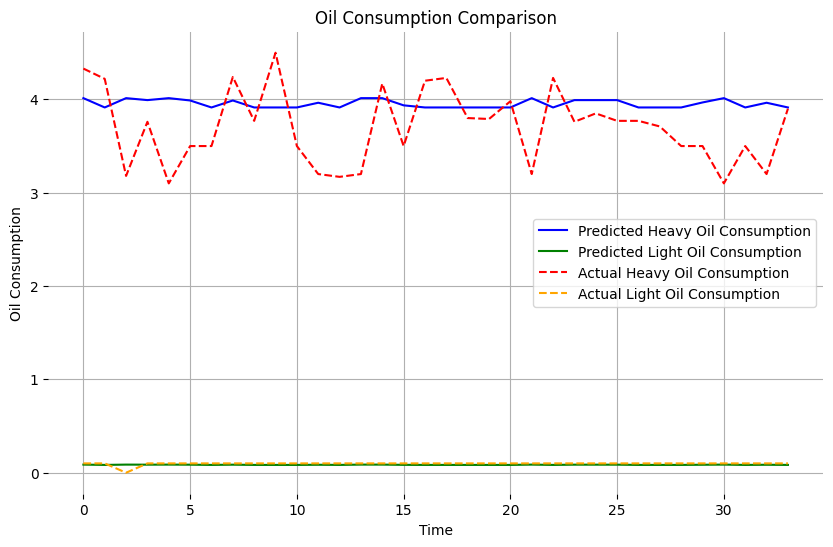

In [15]:
# 提取重油消耗量和轻油消耗量的数据
predicted_heavy_oil = predictions[:, 0]
predicted_light_oil = predictions[:, 1]

actual_heavy_oil = y_test[:, 0]
actual_light_oil = y_test[:, 1]

# 创建一个新的图形并设置标题
plt.figure(figsize=(10, 6))
plt.title('Oil Consumption Comparison')

# 绘制预测值的折线图
plt.plot(predicted_heavy_oil, label='Predicted Heavy Oil Consumption', color='blue')
plt.plot(predicted_light_oil, label='Predicted Light Oil Consumption', color='green')

# 绘制实际值的折线图
plt.plot(actual_heavy_oil, label='Actual Heavy Oil Consumption', linestyle='--', color='red')
plt.plot(actual_light_oil, label='Actual Light Oil Consumption', linestyle='--', color='orange')

# 添加图例和坐标轴标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Oil Consumption')

# 显示图形
plt.grid()
plt.box()
plt.show()

# 航行状态

In [16]:
anchor_data_df = data_df[data_df['状态'] == '航行24h']
anchor_all_data = all_data[all_data['状态'] == '航行24h']


X = anchor_all_data[['实测时速', '推进器转速 r/min', '风向', '浪向', '风级', '浪级', '航向', ]]
y = anchor_all_data[['重油消耗量', '轻油消耗量']]

In [17]:
anchor_all_data

,日期,实测时速,推进器转速 r/min,风向,浪向,风级,浪级,航向,重油消耗量,轻油消耗量,状态
8,2022.1.9,12.0,100.0,NW,NW,5,4,062°,22.54,0.1,航行24h
17,2022.1.18,11.6,99.0,NW,NW,6,5,285°,22.91,0.1,航行24h
24,2022.1.25,13.0,102.0,NW,NW,4,3,107°,20.99,0.1,航行24h
25,2022.1.26,12.7,102.0,NW,NW,5,3,051°,20.60,0.1,航行24h
26,2022.1.27,12.7,102.0,NW,NW,5,3,013°,20.60,0.1,航行24h
...,...,...,...,...,...,...,...,...,...,...,...
345,2022.12.12,9.4,99.0,NE,NE,7,5,012°,22.00,0.1,航行24h
346,2022.12.13,10.0,99.0,NE,NE,6,4,335°,21.84,0.1,航行24h
356,2022.12.23,5.0,99.0,NW,NW,8,5,352°,14.46,0.1,航行24h
357,2022.12.24,7.5,99.0,NW,NW,8,5,352°,21.49,0.1,航行24h


In [18]:
# 对风向和浪向进行独热编码
X = pd.get_dummies(X, columns=['风向', '浪向'])

In [19]:
# 将航向的度数改为数值

headings = X['航向']

# 去除度数符号并转换为整数
headings_numeric = headings.str.replace('°', '').astype(int)


# 替换原始数据中的航向列
X['航向'] = headings_numeric
X

,实测时速,推进器转速 r/min,风级,浪级,航向,风向_NE,风向_NW,风向_SE,风向_SW,浪向_NE,浪向_NW,浪向_SE,浪向_SW
8,12.0,100.0,5,4,62,False,True,False,False,False,True,False,False
17,11.6,99.0,6,5,285,False,True,False,False,False,True,False,False
24,13.0,102.0,4,3,107,False,True,False,False,False,True,False,False
25,12.7,102.0,5,3,51,False,True,False,False,False,True,False,False
26,12.7,102.0,5,3,13,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,9.4,99.0,7,5,12,True,False,False,False,True,False,False,False
346,10.0,99.0,6,4,335,True,False,False,False,True,False,False,False
356,5.0,99.0,8,5,352,False,True,False,False,False,True,False,False
357,7.5,99.0,8,5,352,False,True,False,False,False,True,False,False


In [20]:
X

,实测时速,推进器转速 r/min,风级,浪级,航向,风向_NE,风向_NW,风向_SE,风向_SW,浪向_NE,浪向_NW,浪向_SE,浪向_SW
8,12.0,100.0,5,4,62,False,True,False,False,False,True,False,False
17,11.6,99.0,6,5,285,False,True,False,False,False,True,False,False
24,13.0,102.0,4,3,107,False,True,False,False,False,True,False,False
25,12.7,102.0,5,3,51,False,True,False,False,False,True,False,False
26,12.7,102.0,5,3,13,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,9.4,99.0,7,5,12,True,False,False,False,True,False,False,False
346,10.0,99.0,6,4,335,True,False,False,False,True,False,False,False
356,5.0,99.0,8,5,352,False,True,False,False,False,True,False,False
357,7.5,99.0,8,5,352,False,True,False,False,False,True,False,False


In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print("训练集大小:", X_train.shape[0])
print("验证集大小:", X_val.shape[0])
print("测试集大小:", X_test.shape[0])

训练集大小: 76
验证集大小: 14
测试集大小: 16


In [22]:
#X_train = X[0:len(anchor_data_df)]
X_train = np.asarray(X_train).astype('float32')

#y_train = y[0:len(anchor_data_df)]
y_train = np.asarray(y_train).astype('float32')

In [23]:
#X_train, y_train

In [24]:
#X_test = X[len(anchor_data_df)::]
X_test = np.asarray(X_test).astype('float32')

#y_test = y[len(anchor_data_df)::]
y_test = np.asarray(y_test).astype('float32')

In [25]:
X_test, y_test

(array([[  8.3,  99. ,   8. ,   6. ,  18. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.3,  99. ,   5. ,   4. , 218. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.7, 102. ,   5. ,   3. ,  13. ,   0. ,   1. ,   0. ,   0. ,
           0. ,   1. ,   0. ,   0. ],
        [ 12.6,  99. ,   6. ,   5. ,  44. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 11.9, 101. ,   5. ,   4. , 355. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 10.9,  99. ,   7. ,   5. , 341. ,   0. ,   0. ,   0. ,   1. ,
           0. ,   0. ,   0. ,   1. ],
        [ 11.7, 107. ,   4. ,   2. , 170. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 12.5, 107. ,   4. ,   3. , 190. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 13. , 101. ,   4. ,   3. , 155. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 

In [26]:
# 创建 EarlyStopping 回调对象
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0011,  # 最小改善量
    patience=20,  # 在停止之前等待的轮数
    restore_best_weights=True  # 恢复在验证集上表现最好的权重
)

# 创建神经网络模型
model = Sequential()

# 添加层
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, kernel_initializer='uniform', activation = 'relu'))  # 输出层改为2个单元

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])  # 使用均方误差作为损失函数

# 训练模型
# history = model.fit(X_train, y_train, batch_size=25, epochs=200, callbacks=[early_stopping], validation_split=0.25)
history = model.fit(X_train, y_train, batch_size=25, epochs=2000, validation_split=0.25)

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9124 - loss: 246.9198 - val_accuracy: 1.0000 - val_loss: 250.7911
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9762 - loss: 244.1745 - val_accuracy: 1.0000 - val_loss: 250.6676
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 244.4109 - val_accuracy: 1.0000 - val_loss: 250.5234
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 244.9856 - val_accuracy: 1.0000 - val_loss: 250.3472
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 244.1921 - val_accuracy: 1.0000 - val_loss: 250.1324
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 244.2130 - val_accuracy: 1.0000 - val_loss: 249.8559
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 243.4169 - val_accuracy: 1.0000 - val_loss: 249.4908
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 243.

In [27]:
predictions = model.predict(X_test)
#predictions,y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [28]:
# 计算训练集误差
train_predictions = model.predict(X_train)
train_mse = calculate_mse(y_train, train_predictions)
print("训练集均方误差:", train_mse)

# 计算测试集误差
test_predictions = model.predict(X_test)
test_mse = calculate_mse(y_test, predictions)
print("测试集均方误差:", test_mse)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
训练集均方误差: 3.6113205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
测试集均方误差: 3.2595346


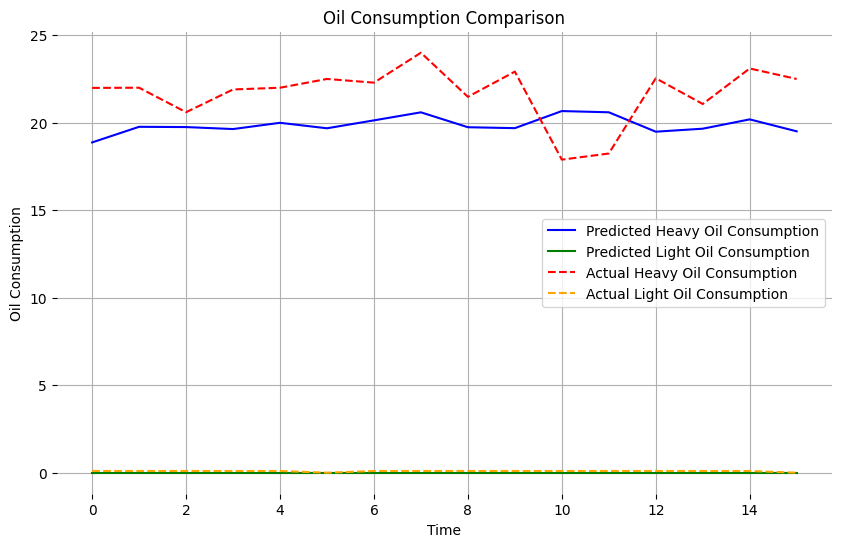

In [29]:
# 提取重油消耗量和轻油消耗量的数据
predicted_heavy_oil = predictions[:, 0]
predicted_light_oil = predictions[:, 1]

actual_heavy_oil = y_test[:, 0]
actual_light_oil = y_test[:, 1]

# 创建一个新的图形并设置标题
plt.figure(figsize=(10, 6))
plt.title('Oil Consumption Comparison')

# 绘制预测值的折线图
plt.plot(predicted_heavy_oil, label='Predicted Heavy Oil Consumption', color='blue')
plt.plot(predicted_light_oil, label='Predicted Light Oil Consumption', color='green')

# 绘制实际值的折线图
plt.plot(actual_heavy_oil, label='Actual Heavy Oil Consumption', linestyle='--', color='red')
plt.plot(actual_light_oil, label='Actual Light Oil Consumption', linestyle='--', color='orange')

# 添加图例和坐标轴标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Oil Consumption')

# 显示图形
plt.grid()
plt.box()
plt.show()

In [30]:
#X_test, y_test